In [6]:
from getpass import getpass
import os

os.environ['HUGGINGFACEHUB_API_TOKEN'] = getpass("Input hugging face API Token")
os.environ['COHERE_API_KEY'] = getpass("Input Cohere API Token")

In [8]:
from sqlalchemy import create_engine,Table, MetaData, Column, String, Date, Integer, Float

metadata = MetaData()
db_engine = create_engine("sqlite:///employees.db")

employees_table = Table(
    "employees", metadata,
    Column("id", Integer, primary_key=True, autoincrement=True),
    Column("first_name", String(50), nullable=False),
    Column("last_name", String(50), nullable=False),
    Column("email", String(100), unique=True, nullable=False),
    Column("phone_number", String(15)),
    Column("hire_date", Date, nullable=False),
    Column("job_title", String(50), nullable=False),
    Column("salary", Float, nullable=False),
    Column("department_id", Integer)
)
# Drop the table if it exists
employees_table.drop(db_engine, checkfirst=True)
metadata.create_all(db_engine)

In [9]:
from sqlalchemy import insert
from datetime import datetime
from random import randint

employees = [
    ['John', 'Doe', 'john.doe@example.com', '123-456-7890', datetime(2021, 5, 1), 'Software Engineer', 70000, 2],
    ['Jane', 'Smith', 'jane.smith@example.com', '234-567-8901', datetime(2020, 8, 15), 'HR Manager', 80000, 1],
    ['Jim', 'Beam', 'jim.beam@example.com', '345-678-9012', datetime(2019, 11, 3), 'Sales Representative', 50000, 3],
    ['Jessica', 'Jones', 'jessica.jones@example.com', '456-789-0123', datetime(2018, 4, 23), 'Marketing Specialist', 60000, 4],
    ['Michael', 'Brown', 'michael.brown@example.com', '567-890-1234', datetime(2022, 1, 9), 'DevOps Engineer', 75000, 2],
    ['Emily', 'Davis', 'emily.davis@example.com', '678-901-2345', datetime(2021, 3, 11), 'Product Manager', 85000, 4],
    ['Daniel', 'Wilson', 'daniel.wilson@example.com', '789-012-3456', datetime(2020, 10, 30), 'Data Scientist', 95000, 2],
    ['Sophia', 'Taylor', 'sophia.taylor@example.com', '890-123-4567', datetime(2021, 6, 7), 'Recruiter', 55000, 1],
    ['Lucas', 'Martinez', 'lucas.martinez@example.com', '901-234-5678', datetime(2019, 2, 18), 'Sales Manager', 70000, 3],
    ['Olivia', 'Garcia', 'olivia.garcia@example.com', '012-345-6789', datetime(2023, 7, 20), 'Junior Developer', 50000, 2]
]

with db_engine.begin() as connection:
    for emp in employees:
        query = insert(employees_table).values(
            id=randint(10000, 99999),
            first_name=emp[0],
            last_name=emp[1],
            email=emp[2],
            phone_number=emp[3],
            hire_date=emp[4],
            job_title=emp[5],
            salary=emp[6],
            department_id=emp[7]
        )
        connection.execute(query)
print("Data inserted Successfully")

Data inserted Successfully


In [10]:
from sqlalchemy import text

with db_engine.begin() as connection:
    result = connection.execute(text("select * from employees")).fetchall()
print(result)

[(11227, 'Emily', 'Davis', 'emily.davis@example.com', '678-901-2345', '2021-03-11', 'Product Manager', 85000.0, 4), (17114, 'Michael', 'Brown', 'michael.brown@example.com', '567-890-1234', '2022-01-09', 'DevOps Engineer', 75000.0, 2), (19166, 'John', 'Doe', 'john.doe@example.com', '123-456-7890', '2021-05-01', 'Software Engineer', 70000.0, 2), (26703, 'Jim', 'Beam', 'jim.beam@example.com', '345-678-9012', '2019-11-03', 'Sales Representative', 50000.0, 3), (29496, 'Jane', 'Smith', 'jane.smith@example.com', '234-567-8901', '2020-08-15', 'HR Manager', 80000.0, 1), (52239, 'Sophia', 'Taylor', 'sophia.taylor@example.com', '890-123-4567', '2021-06-07', 'Recruiter', 55000.0, 1), (73479, 'Daniel', 'Wilson', 'daniel.wilson@example.com', '789-012-3456', '2020-10-30', 'Data Scientist', 95000.0, 2), (85187, 'Jessica', 'Jones', 'jessica.jones@example.com', '456-789-0123', '2018-04-23', 'Marketing Specialist', 60000.0, 4), (88421, 'Olivia', 'Garcia', 'olivia.garcia@example.com', '012-345-6789', '202

In [20]:
from langchain_experimental.sql import SQLDatabaseChain
from langgraph.graph import MessagesState
from langchain_community.utilities import SQLDatabase
from langchain_community.llms.cohere import Cohere

def generate_query(state: MessagesState):
    llm_cohere = Cohere(model = "command-r-plus-08-2024", max_tokens=100, temperature=1)
    sql_chain = SQLDatabaseChain.from_llm(llm_cohere, db=SQLDatabase(db_engine),  return_sql=True, return_direct=True)
    messages = state['messages']
    response = sql_chain.invoke(messages)
    return {"messages": [response['result']]}

def clean_query(state: MessagesState):
    messages = state['messages'][-1]
    corrected_query = messages.content.replace("`","").replace("sql","")
    return {"messages": [corrected_query]}

def execute_query(state: MessagesState):
    messages = state['messages'][-1]
    sql = messages.content
    with db_engine.begin() as connection:
        answer = connection.execute(text(sql)).fetchall()
    return {"messages": [str(answer)]}

In [21]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(MessagesState)

workflow.add_node("Query_Generator", generate_query)
workflow.add_node("Query_Cleaner", clean_query)
workflow.add_node("Query_Executor", execute_query)

workflow.add_edge(START, "Query_Generator")
workflow.add_edge("Query_Generator", "Query_Cleaner")
workflow.add_edge("Query_Cleaner", "Query_Executor")
workflow.add_edge("Query_Executor", END)

graph = workflow.compile()

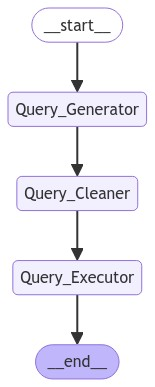

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [23]:
inputs =  {
             "messages": [
                 {"role": "human", "content": "What is the highest salary of all employees? Answer should be in single word or number"}
             ]
         }
for output in graph.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'Query_Generator':
---
{'messages': ['```sql\nSELECT salary FROM employees ORDER BY salary DESC LIMIT 1\n```']}

---

Output from node 'Query_Cleaner':
---
{'messages': ['\nSELECT salary FROM employees ORDER BY salary DESC LIMIT 1\n']}

---

Output from node 'Query_Executor':
---
{'messages': ['[(95000.0,)]']}

---



In [ ]:
inputs =  {
             "messages": [
                 {"role": "human", "content": "What is the Average salary of all employees? Answer should be in single word or number"}
             ]
         }
for output in graph.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

In [24]:
inputs =  {
             "messages": [
                 {"role": "human", "content": "What is the department number of the highest paid employee and what is his/her name? Answer should be in single word or number"}
             ]
         }
for output in graph.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'Query_Generator':
---
{'messages': ['```sql\nSELECT department_id ,  first_name FROM employees WHERE salary  =  ( SELECT MAX(salary) FROM employees )\n```']}

---

Output from node 'Query_Cleaner':
---
{'messages': ['\nSELECT department_id ,  first_name FROM employees WHERE salary  =  ( SELECT MAX(salary) FROM employees )\n']}

---

Output from node 'Query_Executor':
---
{'messages': ["[(2, 'Daniel')]"]}

---



In [22]:
inputs =  {
             "messages": [
                 {"role": "human", "content": "Provide the average salary of each department_id. Answer should be in single word or number"}
             ]
         }
for output in graph.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'Query_Generator':
---
{'messages': ['```sql\nSELECT department_id, AVG(salary) FROM employees GROUP BY department_id\n```']}

---

Output from node 'Query_Cleaner':
---
{'messages': ['\nSELECT department_id, AVG(salary) FROM employees GROUP BY department_id\n']}

---

Output from node 'Query_Executor':
---
{'messages': ['[(1, 67500.0), (2, 72500.0), (3, 60000.0), (4, 72500.0)]']}

---



In [25]:
inputs =  {
             "messages": [
                 {"role": "human", "content": "Provide name, email and salary of employees joined before 2021. first Name and last name should be concatinated with space and in uppercase"}
             ]
         }
for output in graph.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'Query_Generator':
---
{'messages': ['```sql\nSELECT\n    upper(`first_name` || \' \' || `last_name`) AS "name",\n    `email`,\n    salary\nFROM employees\nWHERE strftime(\'%Y\', hire_date) < \'2021\'\n```']}

---

Output from node 'Query_Cleaner':
---
{'messages': ['\nSELECT\n    upper(first_name || \' \' || last_name) AS "name",\n    email,\n    salary\nFROM employees\nWHERE strftime(\'%Y\', hire_date) < \'2021\'\n']}

---

Output from node 'Query_Executor':
---
{'messages': ["[('JIM BEAM', 'jim.beam@example.com', 50000.0), ('JANE SMITH', 'jane.smith@example.com', 80000.0), ('DANIEL WILSON', 'daniel.wilson@example.com', 95000.0), ('JESSICA JONES', 'jessica.jones@example.com', 60000.0), ('LUCAS MARTINEZ', 'lucas.martinez@example.com', 70000.0)]"]}

---

